In [2]:
import pandas as pd
import numpy as np
import json
import os
import gc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Idea of average performace on this challenge

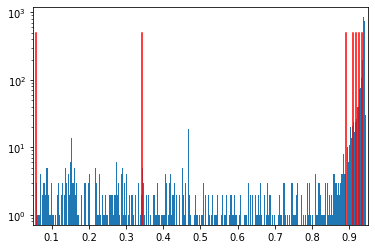

In [3]:
df = pd.read_csv('liverpool-ion-switching-publicleaderboard.csv')
df[df['TeamName']=='cthierfelder']
score = df['Score']
plt.hist(score,bins=np.linspace(np.min(score),np.max(score),1000));
plt.yscale('log')
for s in df[df['TeamName']=='cthierfelder']['Score'].to_numpy():
    pass
    plt.plot([s,s],[0,500],color='red')
    plt.xlim(0.05,0.95)

In [41]:
df

,TeamId,TeamName,SubmissionDate,Score
0,4458093,Adrian Brodzik,2020-02-26 22:37:11,0.047
1,4457240,farmersrice,2020-02-26 22:39:26,0.853
2,4457945,Youri Matiounine,2020-02-26 22:56:59,0.152
3,4458093,Adrian Brodzik,2020-02-26 23:13:36,0.064
4,4458373,Hasni Med Bilel,2020-02-26 23:21:34,0.905
...,...,...,...,...
5347,4462028,DataKiller,2020-03-30 01:20:10,0.940
5348,4590753,cthierfelder,2020-03-30 01:20:29,0.919
5349,4525822,Office Club,2020-03-30 01:25:39,0.939
5350,4597156,FISH,2020-03-30 01:49:59,0.939


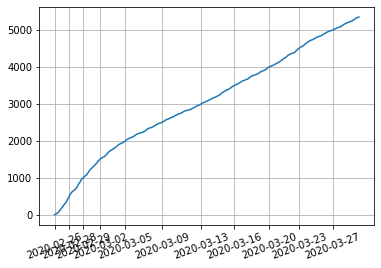

In [54]:
df['Datetime'] = pd.to_datetime(df['SubmissionDate'], format="%Y-%m-%d %H:%M:%S")
plt.plot(df['Datetime'],df.index)
plt.xticks(df['Datetime'][::500], rotation=20)
plt.grid(True)

### Read Data

In [3]:
dfTrain =pd.read_csv('train.csv')
dfTest =pd.read_csv('test.csv')

In [15]:
window = 20
RANDOM_SEED = 42
batch_size = 128
num_classes = 11
epochs = 10 #12

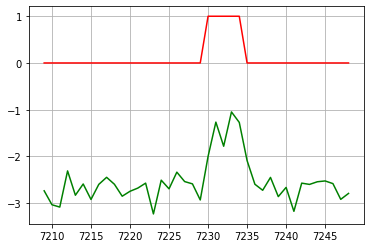

In [5]:
point =7229
sns.lineplot(data=dfTrain.iloc[point-window:point+window].signal,hue="size", size="size",color='green')
sns.lineplot(data=dfTrain.iloc[point-window:point+window].open_channels,hue="size", size="size",color='red')
plt.grid(True)


In [6]:
window = 20
X = np.take(dfTrain['signal'].to_numpy(),[np.arange(i-window,i+window) for i in range(5000000-window+1)])
y = dfTrain['open_channels'].to_numpy()

In [7]:
X_test = np.take(dfTest['signal'].to_numpy(),[np.arange(i-window,i+window) for i in range(2000000-window+1)])
X_test.shape

(1999981, 40)

In [8]:
train_idx, val_idx = train_test_split(np.arange(X.shape[0]), random_state = RANDOM_SEED, test_size = 0.2)

X_train = X[train_idx] 
y_train = y[train_idx] 
X_valid = X[val_idx]
y_valid = y[val_idx]

In [19]:
model = Sequential()
model.add(Dense(16, input_dim=40, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid)
                   )

Train on 3999984 samples, validate on 999997 samples
Epoch 1/5
3999984/3999984 [==============================] - 31s 8us/step - loss: 1.1600 - accuracy: 0.5599 - val_loss: 1.0097 - val_accuracy: 0.6308
Epoch 2/5
3999984/3999984 [==============================] - 32s 8us/step - loss: 1.1583 - accuracy: 0.5609 - val_loss: 1.0128 - val_accuracy: 0.6275
Epoch 3/5
3999984/3999984 [==============================] - 31s 8us/step - loss: 1.1553 - accuracy: 0.5615 - val_loss: 1.0015 - val_accuracy: 0.6374
Epoch 4/5
3999984/3999984 [==============================] - 31s 8us/step - loss: 1.1486 - accuracy: 0.5658 - val_loss: 0.9965 - val_accuracy: 0.6380
Epoch 5/5
3999984/3999984 [==============================] - 31s 8us/step - loss: 1.1455 - accuracy: 0.5693 - val_loss: 0.9976 - val_accuracy: 0.6396


In [25]:
prediction = model.predict(X_valid)
signalPrediction = prediction.argmax(axis=-1)
f1_score(signalPrediction,y_valid,labels=range(11),average='macro')

0.4522811254098942

In [ ]:
#Dense(16,input40,relu),Dense(12,relu),Dropout(0.5,softmax),Dense(num_classes=11)                 f1_score valid 0.42277
#Dense(16,input40,relu),Dense(12,relu),Dense(12,relu),Dropout(0.5,softmax),Dense(num_classes=11)  f1_score valid 0.45228

In [13]:
prediction = model.predict(X_test)
signalPrediction = prediction.argmax(axis=-1)
signalPrediction=np.pad(signalPrediction, (0, window-1), 'constant', constant_values=(0,0))
signalPrediction= signalPrediction.astype(int)

In [14]:
time=np.linspace(5000001,7000000,2000000).astype(int).astype(str)
for i in range(len(time)):
    time[i]=time[i][:3]+'.'+time[i][3:]

df=pd.DataFrame(data={'time':time,'open_channels':signalPrediction})
df.to_csv('ion_CT_cnn01.csv', index=False)